In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from read_emg import *
import seaborn as sns
from IPython.display import Image
import seaborn as sns
import os

plt.style.use('seaborn-bright')
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.title_fontsize'] = 14
pd.options.display.float_format = "{:,.3f}".format
sns.set(font_scale=1.5)

In [2]:
%%time
df = read_file()
df.to_pickle('DataCollection.pkl')

100%|██████████████████████████████████████████████████████████████████████████████| 1242/1242 [00:53<00:00, 23.33it/s]


Wall time: 55.1 s


In [3]:
### Reads the EMG data (healthy subjects)
df = pd.read_pickle('DataCollection.pkl')
df['Trial_num'] = df['Trial_num'].astype(int)

In [4]:
def set_custom_palette(series, max_color = 'red', other_color = 'orange'):
    max_val = series.max()
    pal = []
    
    for item in series:
        if item == max_val:
            pal.append(max_color)
        else:
            pal.append(other_color)
    return pal

In [5]:
### Calculating the similarity using the channel means
def cross_correlation_vector(A, B):
    A_vector = []
    B_vector = []
    for channel in range(0, A.shape[1]):
        A_temp = A[:, channel] 
        A_channel_mean = A_temp.mean()
        A_vector.append(A_channel_mean)
        
        B_temp = B[:, channel]
        B_channel_mean = B_temp.mean()
        B_vector.append(B_channel_mean)
        
    A_vector = np.array(A_vector)
    B_vector = np.array(B_vector)
    C = np.multiply(A_vector, B_vector).sum() / (np.sqrt((A_vector**2).sum() * (B_vector**2).sum()))

    return C

In [6]:
def flipping_sensor(df_unflipped):
    A = df_unflipped.iloc[:, :8]
    A = A.loc[:, ::-1].values
    
    df_flipped = df_unflipped.copy()
    df_flipped.iloc[:, :8] = A
    
    return df_flipped

In [7]:
def CC_to_shift(df, subject_reference, subject_to_rotate, calibration_gesture_list, session_reference, session_to_rotate, ax):
#     print(f'Current Subject: {subject_to_rotate}')
    shift_range = range(0, 8)

    max_CC = 0
    final_status = False
    final_shift = 0

    ## Reference session will not get flipped, but the test session
    CC_list = []
    for flipped in [False, True]:

        for shift in shift_range:
            A_vector_all_gesture = np.zeros(shape = (1, len(calibration_gesture_list) * 8))
            B_vector_all_gesture = np.zeros(shape = (1, len(calibration_gesture_list) * 8))
#             print(f'Shift: {shift}')

            for calibration_gesture in calibration_gesture_list:
                df_A = df[(df['ID'] == subject_reference) & 
                          (df['Gesture'] == calibration_gesture) & 
                          (df['Trial_num'] <= 3) & 
                          (df['session'] == session_reference)].iloc[:, :8]            
                df_A = df_A[df_A.index > 100]
                A_value = df_A.iloc[:, :8].rolling(1).mean().dropna().values

                ## concatenation of all gestures for sessionA
                ## Check if it is all zeros, if so, replace that with the first gesture
                ## If not, concatenate the 2nd gesture with the first one and so on
                if not np.any(A_vector_all_gesture):
                    A_vector_all_gesture = A_value
                else:
                    length = np.minimum(len(A_vector_all_gesture), len(A_value))
                    A_vector_all_gesture = np.concatenate((A_vector_all_gesture[:length], A_value[:length]), axis = 1)

                if flipped == False:    

                    df_B = df[(df['ID'] == subject_to_rotate) & 
                              (df['Gesture'] == calibration_gesture) & 
                              (df['Trial_num'] <= 3) & 
                              (df['session'] == session_to_rotate)].iloc[:, :8]
                else:
    #                 print('Flipping the sensor\n')
                    df_B = flipping_sensor(df[(df['ID'] == subject_to_rotate)  & 
                                              (df['Gesture'] == calibration_gesture) & 
                                              (df['Trial_num'] <= 3) & 
                                              (df['session'] == session_to_rotate)]).iloc[:, :8]

                df_B = df_B[df_B.index > 100]
                B = df_B.iloc[:, :8].rolling(1).mean().dropna()     

                B_value = pd.concat((B,B), axis = 1).iloc[:,  0 + shift:8 + shift].values

                ## concatenation of all gestures for sessionB (shift indiviually and concatenate)
                ## Check if it is all zeros, if so, replace that with the first gesture
                ## If not, concatenate the 2nd gesture with the first one and so on
                if not np.any(B_vector_all_gesture):
                    B_vector_all_gesture = B_value
                else:
                    length = np.minimum(len(B_vector_all_gesture), len(B_value))
                    B_vector_all_gesture = np.concatenate((B_vector_all_gesture[:length], B_value[:length]), axis = 1)

            C = cross_correlation_vector(A_vector_all_gesture, B_vector_all_gesture)
#             print(f'CC: {C:.4f}\n')
            CC_list.append(C)

    try:
        shift_max = np.where(CC_list == np.max(CC_list))[0][0]
        palette = set_custom_palette(pd.Series(CC_list))

        if shift_max < 8:
            final_status = False
            final_shift = shift_max
        else:
            final_status = True
            final_shift -= 8
            
        
        ax.bar(x = ['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7',
                           'F_S0', 'F_S1', 'F_S2', 'F_S3', 'F_S4', 'F_S5', 'F_S6', 'F_S7'], 
                       height = CC_list, alpha = 0.7, color = palette)

        ax.set_title(subject)
        ax.set_ylabel('Cross-correlation')
        plt.setp(ax.get_xticklabels(), rotation=45)

    except Exception as e:
        print(e)

#     print(f'Flipping needed? {final_status}\n')
    return final_status, final_shift


In [8]:
def shift_to_rotation(df, shift, subject_reference, subject_to_rotate, session_reference, session_to_rotate, flipped):
    df_train = df[(df['ID'] == subject_reference) & (df['session'] == session_reference) & (df['Trial_num'] <=3)]
        
    df_test = df[(df['ID'] == subject_to_rotate) & (df['session'] == session_to_rotate) & (df['Trial_num'] <=3)]
    

    df_test_temp = df_test.iloc[:, :8].copy()
    
    if flipped == True:
        df_test_temp = flipping_sensor(df_test.iloc[:, :8])
        df_test = flipping_sensor(df_test)
        
    df_test_calibrated = pd.concat((pd.concat((df_test_temp, df_test_temp), axis = 1).iloc[:,  0 + shift:8 + shift], df_test.iloc[:, 8:]), axis = 1)
    df_test_calibrated = pd.DataFrame(df_test_calibrated.values, columns = df_test.columns)
            
    return df_train, df_test, df_test_calibrated

# Use only 1 gesture to align the rotation and flipping
Known fact: 

Subject 0100, 1008 and 9998 worn the sensor upside down, the highest correlation should appear in the later half (flipped and shift)

Subject 1234 deliberately worn the sensor rotated (2 sensors away), the highest correlation should appear either in S2 or S6

## Wrist and finger extension (label: '8')

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:37<00:00,  6.10s/it]


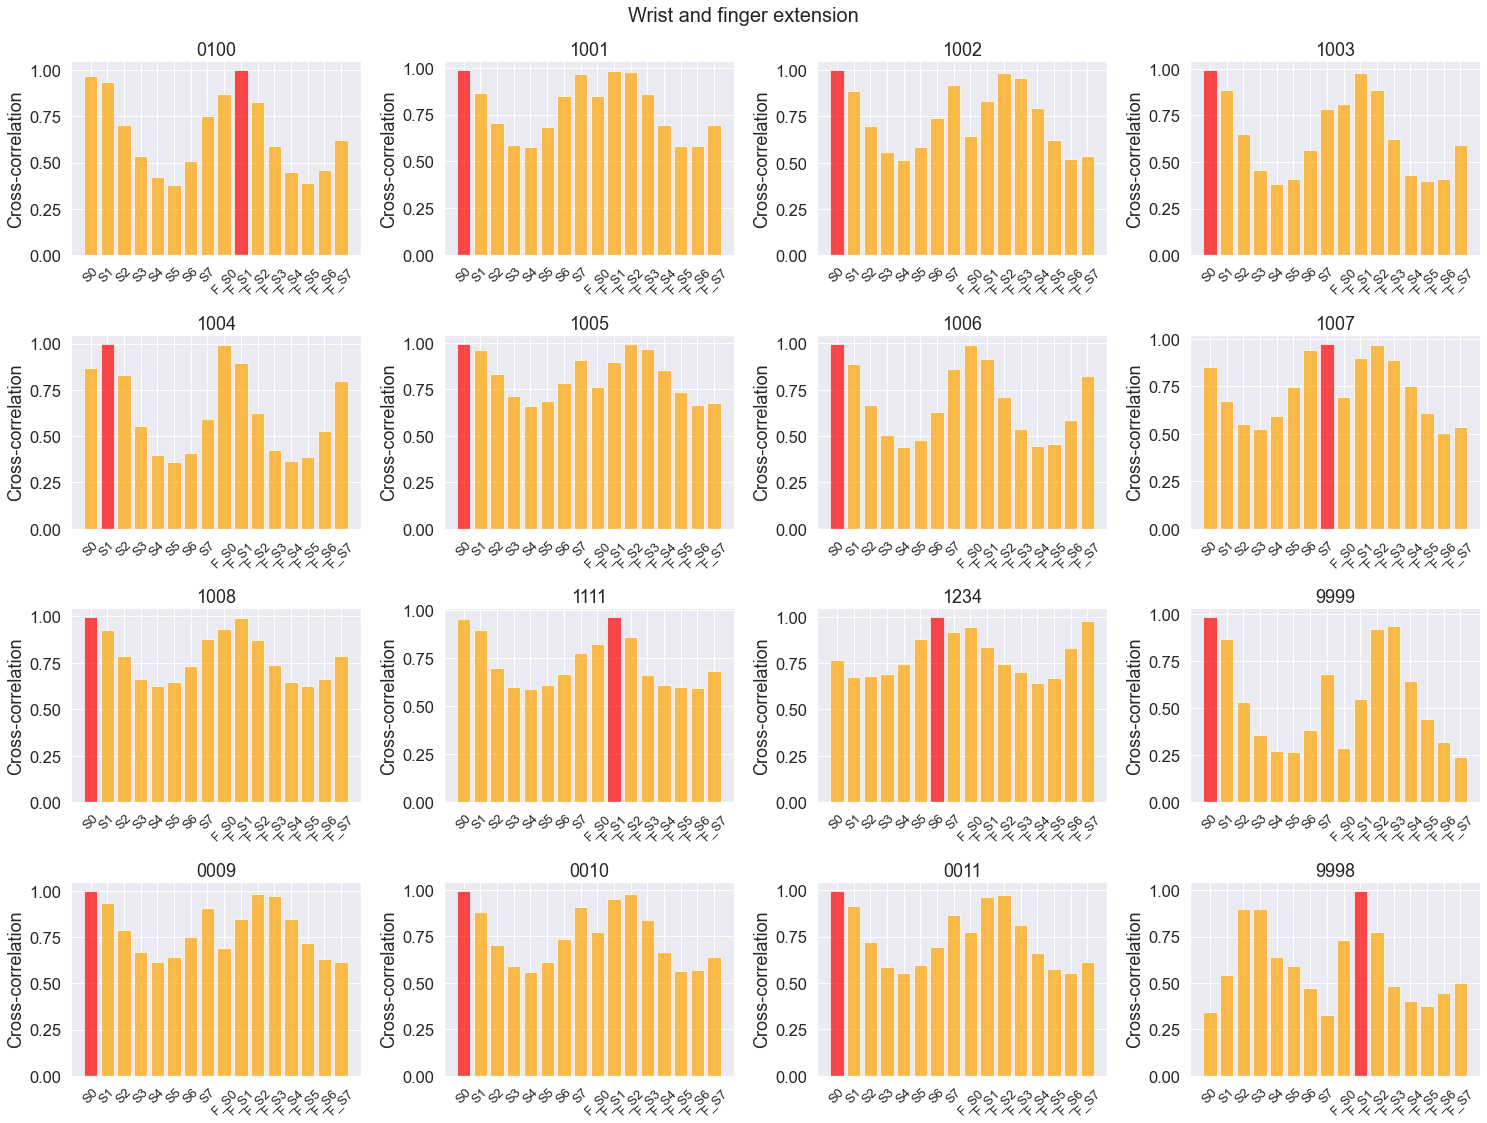

In [19]:
### Wrist and finger extension

fig, ax = plt.subplots(4, 4, figsize = (21, 16))
fig.suptitle('Wrist and finger extension', fontsize = 20)
R = 0 
Col = 0
for subject in tqdm(['0100', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1111', '1234', '9999', '0009', '0010', '0011', '9998']):
        
    flipped, shift = CC_to_shift(df, 
                        subject_reference = subject, 
                        subject_to_rotate = subject, 
                        calibration_gesture_list = ['8'], 
                        session_reference = 'S1', 
                        session_to_rotate = 'S2', ax = ax[R, Col])
    ax[R, Col].xaxis.set_tick_params(labelsize=13)
    Col += 1
    if Col == 4:
        Col = 0
        R += 1
    
plt.tight_layout()

# Use 3 gestures to align the rotation and flipping 

## Wrist and finger extension, fist and wrist extension

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [05:40<00:00, 21.25s/it]


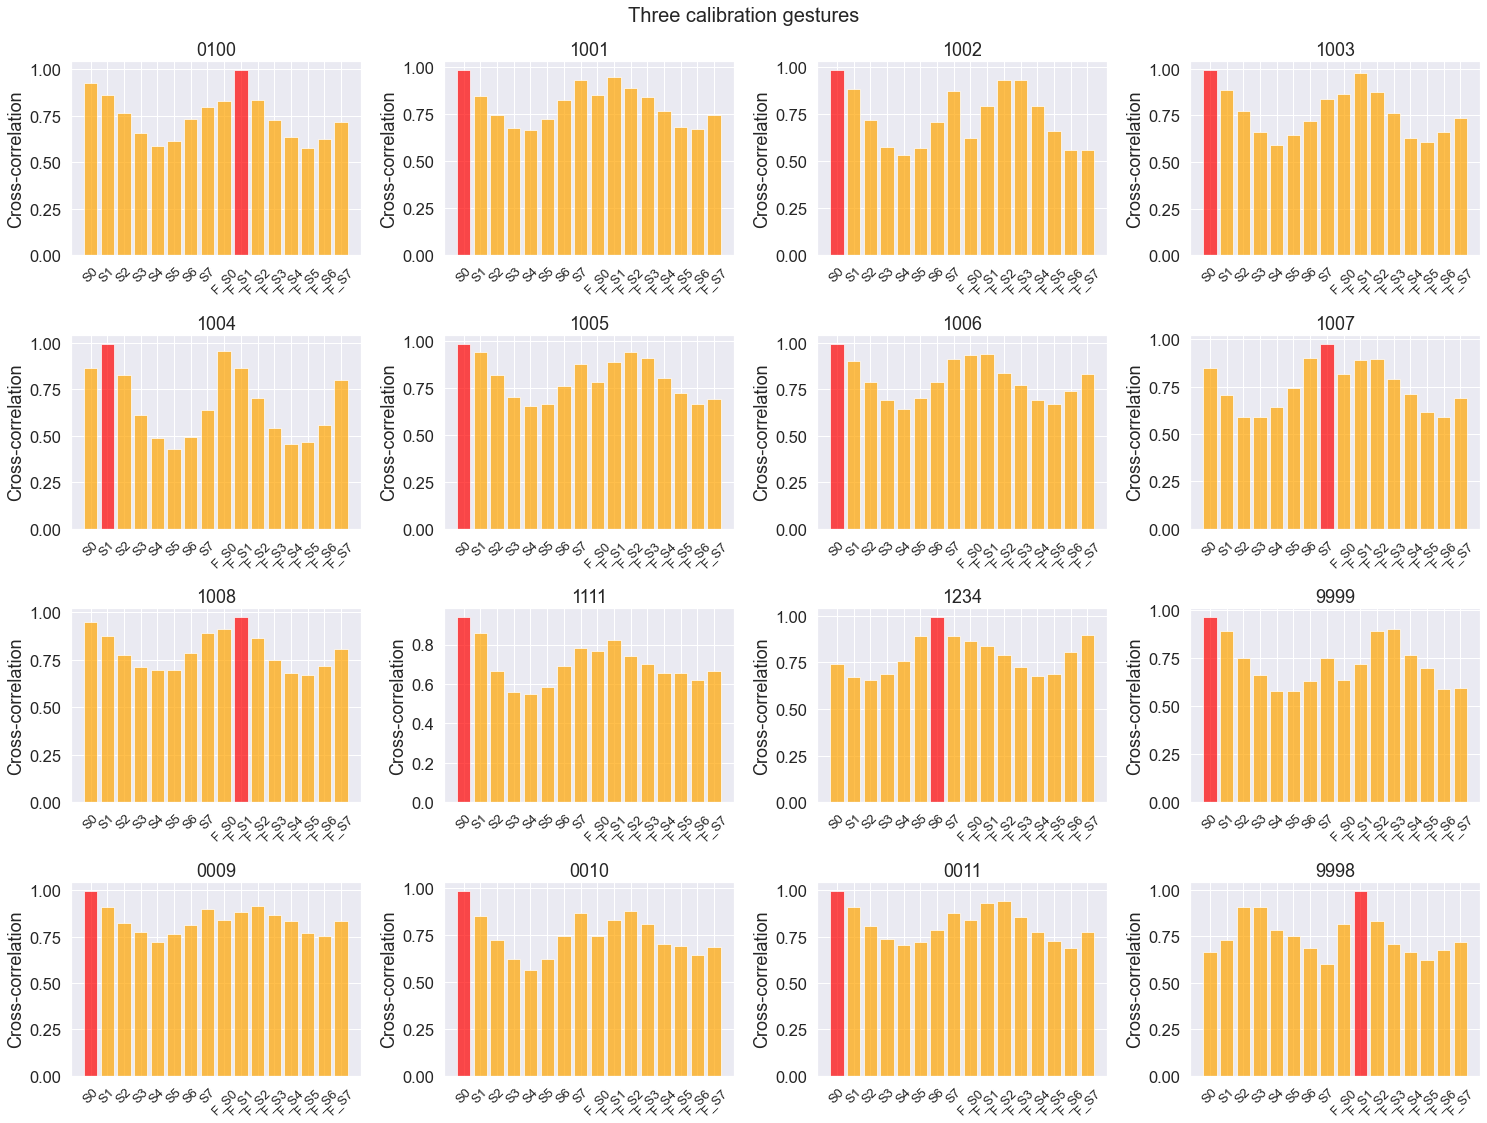

In [21]:
fig, ax = plt.subplots(4, 4, figsize = (21, 16))
fig.suptitle('Three calibration gestures', fontsize = 20)
R = 0 
Col = 0
for subject in tqdm(['0100', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1111', '1234', '9999', '0009', '0010', '0011', '9998']):
        
    flipped, shift = CC_to_shift(df, 
                        subject_reference = subject, 
                        subject_to_rotate = subject, 
                        calibration_gesture_list = ['8', '5', '4'], 
                        session_reference = 'S1', 
                        session_to_rotate = 'S2', ax = ax[R, Col])
    ax[R, Col].xaxis.set_tick_params(labelsize=13)
    Col += 1
    if Col == 4:
        Col = 0
        R += 1
    
plt.tight_layout()

Summary: 

Decision made by these two approaches differ only in subject 1111 and 1008. Our algorithm made wrong decisions in subject 1111 and 1008 with only wrist and finger extension as the calibration gestrue (sensor should not be flipped being flipped or vice versa). However, with 3 the least correlated gestures, the algorithm was able to identify the correct orientation.